# Recommendation System Project: IBM Community


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>



In [29]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [30]:
df['email'].isna().sum()

np.int64(17)

In [31]:
print(f"Number of Null email values is:", df['email'].isna().sum())

Number of Null email values is: 17


In [32]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [33]:
# Fill email NaNs with "unknown_user"
df['email'].fillna('unknown_user', inplace= True)

/tmp/ipykernel_13/2369369865.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['email'].fillna('unknown_user', inplace= True)


In [34]:
# Check if no more NaNs 
df[df['email'].isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [35]:
# What are the descriptive statistics of the number of articles a user interacts with?
user_article_counts = df.groupby('email')['article_id'].count()
user_article_counts

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
unknown_user                                17
Name: article_id, Length: 5149, dtype: int64

In [36]:
user_article_counts.describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

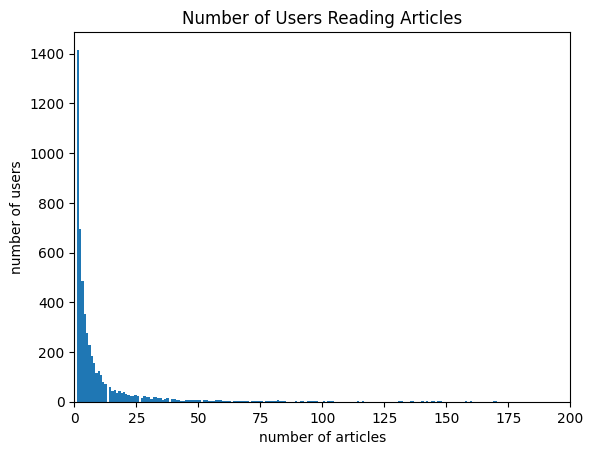

In [37]:
# Create a plot of the number of articles read by each user
plt.hist(user_article_counts, bins='auto')
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.xlim([0,200])
plt.show()

In [38]:
art_read_count = df.groupby('article_id')['email'].count()
art_read_count

article_id
0       14
2       58
4       13
8       85
9       10
        ..
1440    10
1441     8
1442     4
1443    22
1444     5
Name: email, Length: 714, dtype: int64

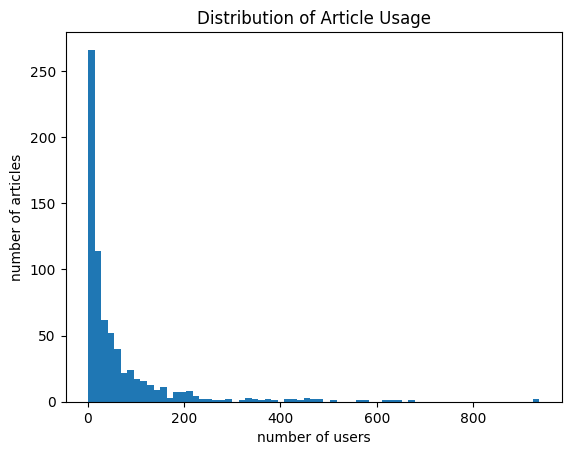

In [39]:
# Create a plot of the number of times each article was read
plt.hist(art_read_count, bins=('auto'))
plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.show()

In [40]:
# Fill in the median and maximum number of user_article interactions below

median_val = user_article_counts.describe().loc['50%'] # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_article_counts.describe().loc['max'] # The maximum number of user-article interactions by any 1 user is ______.

In [41]:
# Sanity Check

print(median_val)
print(max_views_by_user)

3.0
364.0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [42]:
art_read_count[art_read_count>=1].count()

np.int64(714)

In [43]:
df['article_id'].nunique()

714

In [44]:
df['email'].nunique()

5149

In [45]:
df.shape[0]

45993

In [46]:
unique_articles = art_read_count[art_read_count>=1].count() # The number of unique articles that have at least one interaction
total_articles = df['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [47]:
art_read_count.describe()

count    714.000000
mean      64.415966
std      109.175923
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: email, dtype: float64

In [48]:
art_read_count[art_read_count == 937]

article_id
1429    937
Name: email, dtype: int64

In [49]:
most_viewed_article_id = 1429 # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [50]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [51]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top.

In [52]:
df['title'].value_counts().head(5).index.tolist()

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [53]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    
    top_articles = df['title'].value_counts().head(n).index.tolist()
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    
    top_articles = df['article_id'].value_counts().head(n).index.tolist()
    return top_articles # Return the top article ids

In [54]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [55]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix

    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with
    an article and a 0 otherwise
    """

    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item = user_item.fillna(fill_value)
    
    # Convert interaction counts to binary (1 for interaction, 0 for no interaction)
    user_item = user_item.map(lambda x: 1 if x > fill_value else x)
    user_item = user_item.astype(int) # Convert all values to integers
    return user_item  # return the user_item matrix

In [56]:
# Let's use the function that we just created
user_item = create_user_item_matrix(df)
user_item

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [57]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [58]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.

    """
    # compute similarity of each user to the provided user
    similarity_matrix = cosine_similarity(user_item)
    user_index = user_item.index.get_loc(user_id)
    user_similarity = similarity_matrix[user_index]

    # sort by similarity
    # remove the own user's id
    similar_users_indices = user_similarity.argsort()[::-1]
    similar_users_indices = similar_users_indices[similar_users_indices != user_index]
    
    # create list of just the ids
    most_similar_users = user_item.iloc[similar_users_indices].index.tolist()

    # create list of just the similarities
    similarity_values = user_similarity[similar_users_indices].tolist()

    if include_similarity:
        # return a list of lists with [[similar_user_id, similarity], ...]
        return [[user_id, similarity] for user_id, similarity in zip(most_similar_users, similarity_values)]
    
    return most_similar_users # return a list of the users in order from most to least similar

In [59]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.

    """
    # compute similarity of each user to the provided user
    similarity_matrix = cosine_similarity(user_item)
    user_index = user_item.index.get_loc(user_id)
    user_similarity = similarity_matrix[user_index]

    # sort by similarity
    # remove the own user's id
    similar_users_indices = user_similarity.argsort()[::-1]
    similar_users_indices = similar_users_indices[similar_users_indices != user_index]
    
    # create list of just the ids
    most_similar_users = user_item.iloc[similar_users_indices].index.tolist()

    # create list of just the similarities
    similarity_values = user_similarity[similar_users_indices].tolist()

    if include_similarity:
        # return a list of lists with [[similar_user_id, similarity], ...]
        return [[user_id, similarity] for user_id, similarity in zip(most_similar_users, similarity_values)]
    
    return most_similar_users # return a list of the users in order from most to least similar

In [60]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 4201, 46, 824, 5034, 253, 5041, 2305, 136, 395]
The 5 most similar users to user 3933 are: [1, 46, 4201, 253, 824]
The 3 most similar users to user 46 are: [4201, 790, 5077]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [36]:
user_item

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
    article_ids = [2, 4, 8, 9]
    article_names = []
    for article_id in article_ids:
        article_names.append(df[df['article_id'] == article_id]['title'].unique())
        
    article_names

[array(['this week in data science (april 18, 2017)'], dtype=object),
 array(['analyze ny restaurant data using spark in dsx'], dtype=object),
 array(['data science bowl 2017'], dtype=object),
 array(['3992    using apache spark to predict attack vectors a...\nName: title, dtype: object'],
       dtype=object)]

In [214]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    article_names = []
    for article_id in article_ids:
        article_names.extend(df[df['article_id'] == article_id]['title'].unique())
    
    
    return article_names # Return the article names associated with list of article ids

def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    article_ids - (int) list of article_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """
    
    article_counts = []
    for article_id in article_ids:
        # Get the number of unique users who interacted with the article
        unique_users_count = user_item[article_id].sum()
        article_counts.append([article_id, int(unique_users_count)])
        
    ranked_article_unique_counts = sorted(article_counts, key=lambda x: x[1], reverse=True)
    return ranked_article_unique_counts


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    user_row = user_item.loc[user_id]
    article_ids = user_row[user_row == 1].index.tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    """
    # Get the articles seen by the user
    user_article_ids, _ = get_user_articles(user_id)
    
    # Now let's get the most similar users using our cosine similarity function above!
    similar_users = find_similar_users(user_id)
    
    # Empty list to populate later
    recs = []
    
    # Let's loop through similar users from our cosine similarty function and find articles that
    # similar users have seen but not our main user.
    for similar_user in similar_users:
        similar_user_article_ids, _ = get_user_articles(similar_user)
        new_recs = np.setdiff1d(similar_user_article_ids, user_article_ids, assume_unique=True)
        recs.extend(new_recs)
        
    # If we have enough recommendations, break the loop
        if len(recs) >= m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [201]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'this week in data science (may 2, 2017)',
 'top 20 r machine learning and data science packages',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'using apply, sapply, lapply in r',
 'awesome deep learning papers',
 'leverage python, scikit, and text classification for behavioral profiling',
 'challenges in deep learning',
 'do i need to learn r?',
 'how can data scientists collaborate to build better business']

In [41]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [62]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise


    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user

    Other Details - sort the neighbors_df by the similarity and then by number of interactions where
                    highest of each is higher in the dataframe, i.e. Descending order

    """
    # find similar users and their similarity
    similar_users_with_similarity = find_similar_users(user_id, user_item, include_similarity=True)

    # remove the own user's id
    similar_users_with_similarity = [user for user in similar_users_with_similarity if user[0] != user_id]

    # create a dataframe with neighbor_id and similarity
    neighbors_df = pd.DataFrame(similar_users_with_similarity, columns=['neighbor_id', 'similarity'])

    # add num_interactions column
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: user_item.loc[x].sum())

    # sort the dataframe
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """
    # Get the articles seen by the user
    user_article_ids, _ = get_user_articles(user_id)

    # Get the top sorted users
    top_sorted_users = get_top_sorted_users(user_id)

    # Empty list to populate later
    recs = []

    # Loop through the top sorted users
    for neighbor_id in top_sorted_users['neighbor_id']:
        # Get the articles seen by the neighbor
        neighbor_article_ids, _ = get_user_articles(neighbor_id)

        # Find articles that the neighbor has seen but the user hasn't
        new_recs = np.setdiff1d(neighbor_article_ids, user_article_ids, assume_unique=True)

        # Rank the new recommendations by popularity
        ranked_new_recs = get_ranked_article_unique_counts(new_recs)

        # Add the ranked recommendations to the recs list
        for rec in ranked_new_recs:
            recs.append(rec[0])
            
        # If we have enough recommendations, break the loop
        if len(recs) >= m:
            break

    # Return the top m recommendations
    return recs[:m], get_article_names(recs[:m])

In [63]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[np.int64(1185), np.int64(1162), np.int64(1165), np.int64(1293), np.int64(1185), np.int64(1165), np.int64(1293), np.int64(254), np.int64(1271), np.int64(1328)]

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'analyze precipitation data', 'finding optimal locations of new store using decision optimization', 'classify tumors with machine learning', 'analyze precipitation data', 'finding optimal locations of new store using decision optimization', 'apple, ibm add machine learning to partnership with watson-core ml coupling', 'customer demographics and sales', 'income (2015): united states demographic measures']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [65]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
    neighbor_id  similarity  num_interactions
0          5083    0.730297                 5
1          1552    0.577350                 2
2          1890    0.577350                 2
3          1372    0.471405                 3
4          2941    0.433013                 8
22         3586    0.408248                 4
5          2608    0.408248                 1
6          3630    0.408248                 1
7          1131    0.408248                 1
8          2419    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1         4459    0.388909                96
2          203    0.388909                96
3         3782    0.387585               135
4           40    0.384308                52
5         4932    0.384308                52
6           23    0.377647               135
7          242    0.375823                59

In [71]:
### Tests with a dictionary of results
user1_most_sim =  3933# Find the user that is most similar to user 1 
user2_6th_sim = 3586 # Find the 6th most similar user to user 2
user131_10th_sim = 383 # Find the 10th most similar user to user 131

In [72]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:
We would use Ranked Based Recommendations as we do not have any data on them to match them up with similar users. Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [79]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [164]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [81]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [165]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [166]:
# unique articles
df_unique_articles = df['title'].unique().tolist()
df_unique_articles

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'healthcare python streaming application demo',
 'use deep learning for image classification',
 'ml optimization using cognitive assistant',
 'deploy your python model as a restful api',
 'visualize data with the matplotlib library',
 'upload files to ibm data science experience using the command line',
 'classify tumors with machine learning',
 'configuring the apache spark sql context',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'the unit commitment problem',
 'apache spark lab, part 1: basic concepts',
 'getting started with python',
 'timeseries data analysis of iot events by using jupyter notebook',
 '10 must attend data science, ml and ai conferences in 2018',
 'housing (2015): united states demographic measures',
 'access db2 warehouse on cloud and db2 with python',
 'the nurse assignment problem',
 'dsx: hybrid mode',
 'predicting churn with the spss random t

In [167]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf =  vectorizer.fit_transform(df_unique_articles)

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)# Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

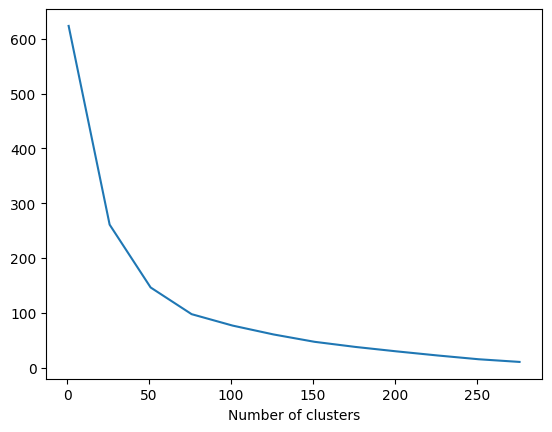

In [88]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [168]:
n_clusters = 50# Number of clusters
kmeans = KMeans(n_clusters=50, max_iter=max_iter,
        n_init=n_init,
        random_state=random_state).fit(X_lsa)

In [171]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
article_cluster_map = {} # Map article_id to cluster label

# Create a dictionary mapping article titles to cluster labels
for i, title in enumerate(df_unique_articles):
    article_cluster_map[title] = kmeans.labels_[i]

# Apply the mapping to create the 'title_cluster' column in the DataFrame
df['title_cluster'] = df['title'].map(article_cluster_map)

In [172]:
article_cluster_map

{'using pixiedust for fast, flexible, and easier data analysis and experimentation': np.int32(22),
 'healthcare python streaming application demo': np.int32(29),
 'use deep learning for image classification': np.int32(13),
 'ml optimization using cognitive assistant': np.int32(41),
 'deploy your python model as a restful api': np.int32(16),
 'visualize data with the matplotlib library': np.int32(5),
 'upload files to ibm data science experience using the command line': np.int32(7),
 'classify tumors with machine learning': np.int32(12),
 'configuring the apache spark sql context': np.int32(15),
 'got zip code data? prep it for analytics. – ibm watson data lab – medium': np.int32(11),
 'the unit commitment problem': np.int32(42),
 'apache spark lab, part 1: basic concepts': np.int32(15),
 'getting started with python': np.int32(16),
 'timeseries data analysis of iot events by using jupyter notebook': np.int32(22),
 '10 must attend data science, ml and ai conferences in 2018': np.int32(2

In [236]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 23],
       [ 1, 11],
       [ 2,  6],
       [ 3, 66],
       [ 4, 20],
       [ 5, 32],
       [ 6, 20],
       [ 7, 15],
       [ 8, 10],
       [ 9, 29],
       [10, 28],
       [11, 22],
       [12, 36],
       [13, 22],
       [14, 16],
       [15, 25],
       [16, 20],
       [17, 10],
       [18, 13],
       [19, 11],
       [20,  9],
       [21, 12],
       [22, 13],
       [23,  9],
       [24,  7],
       [25, 15],
       [26, 16],
       [27,  8],
       [28, 15],
       [29,  8],
       [30, 11],
       [31,  6],
       [32,  3],
       [33,  8],
       [34, 13],
       [35,  9],
       [36, 10],
       [37,  8],
       [38,  7],
       [39, 10],
       [40,  8],
       [41, 12],
       [42,  5],
       [43, 10],
       [44,  5],
       [45, 11],
       [46,  7],
       [47,  8],
       [48,  3],
       [49, 13]])

In [243]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster

    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # lets find out what cluster the article is in
    title_cluster = df[df['article_id'] == article_id]['title_cluster'].values[0]
    articles_in_cluster = df[df['title_cluster'] == title_cluster]['article_id'].unique().tolist()

    # remove the input article_id from the list
    articles_in_cluster.remove(article_id) 
    return articles_in_cluster

In [244]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids

    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    
    # Get similar articles
    similar_articles = get_similar_articles(article_id, df)

    # Rank similar articles by popularity
    ranked_similar_articles = get_ranked_article_unique_counts(similar_articles, user_item)

    # Get the top n ranked articles
    n_ranked_similar_articles = []
    for i in range(min(n, len(ranked_similar_articles))):
        n_ranked_similar_articles.append(ranked_similar_articles[i][0])

    # Get the names of the top n ranked articles
    n_ranked_article_names = get_article_names(n_ranked_similar_articles, df)

    return n_ranked_similar_articles, n_ranked_article_names


In [246]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10, df=df)
print(rec_article_ids)
print(rec_article_titles)

[1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352]
['data tidying in data science experience', 'upload files to ibm data science experience using the command line', 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics', 'using rstudio in ibm data science experience', 'use ibm data science experience to detect time series anomalies', 'experience iot with coursera', 'use ibm data science experience to read and write data stored on amazon s3', 'better together: spss and data science experience', 'data science platforms are on the rise and ibm is leading the way', 'how ibm builds an effective data science team']


In [247]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

This content-based recommendation system leverages the textual content of articles, specifically their titles, to identify and recommend similar articles. 

#### It works through the following steps in order: 

1. Text Processing and Feature Extraction
2. Dimensionality Reduction
3. Clustering
4. Recommendation Generation

#### Possible Improvements: 
Incorporating More Textual Data: Currently, the system only uses article titles. Including more textual content like article descriptions, tags, or even the full article body could significantly improve the accuracy and relevance of the recommendations.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [248]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [249]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

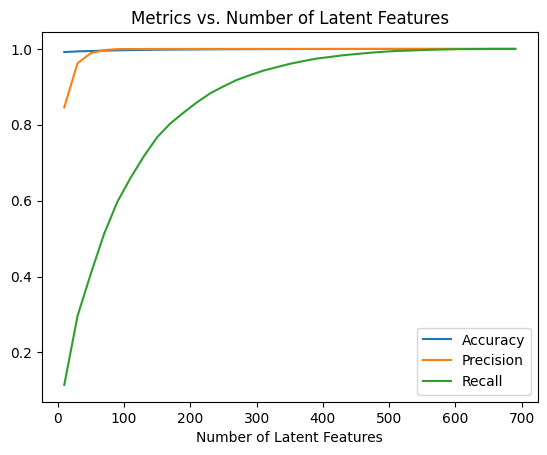

In [250]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

As you increase the number of latent features, the metrics overall improve. This is because more latent features allow the model to capture more complex patterns and relationships in the user-item interaction data. At some point, the improvement in metrics starts to plateau or the rate of improvement decreases significantly. This indicates that adding more latent features beyond this point provides diminishing returns. Using an excess amount of latent features can also risk overfitting and that is something we have to keep in mind. If I were pick the number of latent feature I would try to maximize metrics but also consider bandwidth, so using the elbow method, I would choose somewhere around ~300. 

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [251]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Find the index of the article_id
    article_idx = user_item.columns.get_loc(article_id)
    # Find the cosine similarity of all articles
    # Hint: vt should be transposed before passing to cosine_similarity to get a 714 x 714 matrix
    cos_sim = cosine_similarity(vt.T)
    # Get similarities only for the cos_sim of the article_idx
    article_similarities = cos_sim[article_idx]
    # Sort and return the articles, don't include the own article
    most_similar_items = np.argsort(article_similarities)[::-1]
    most_similar_items = most_similar_items[most_similar_items != article_idx]
    most_similar_items = user_item.columns[most_similar_items].tolist()

    if include_similarity:
        # Get the similarity values for the most similar items
        similarity_values = article_similarities[most_similar_items]
        # Return a list of lists with [[similar_article_id, similarity], ...]
        return [[article_id, similarity] for article_id, similarity in zip(most_similar_items, similarity_values)]
    return most_similar_items

In [252]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [253]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [254]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [255]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['country statistics: crude oil - exports',
 'airbnb data for analytics: athens reviews',
 'use spark r to load and analyze data',
 'country statistics: crude oil - proved reserves',
 'top analytics tools in 2016',
 'airbnb data for analytics: paris calendar',
 'notebooks: a power tool for data scientists',
 '10 powerful features on watson data platform, no coding necessary',
 'advancements in the spark community',
 'collecting data science cheat sheets']

In [256]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

To determine if the SVD recommendations are an improvement over existing methods, we could conduct an A/B test. We would split users into two groups:

> Control group: Receives recommendations using the current method (e.g., rank-based, collaborative filtering, or content-based).

> Treatment group: Receives recommendations using the SVD method.

We would then track metrics such as click-through rates, article engagement, and user satisfaction to see if the SVD method leads to improved outcomes.


Different recommendation methods have strengths and weaknesses. Rank-based is simple but not personalized. Collaborative filtering is personalized but needs user history. Content-based uses article features but might lack diversity. Matrix factorization can find hidden relationships but is computationally expensive. For new users, use rank-based or content-based. As users interact more, blend in collaborative filtering and matrix factorization for better personalization. A hybrid approach, combining multiple methods, is generally the most effective.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [257]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/venv/lib/python3.10/site-packages/nbconvert/__main__.py", line 5, in <module>
    main()
  File "/opt/venv/lib/python3.10/site-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/opt/venv/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 582, in convert_notebooks
    raise ValueError(msg)
ValueError: Please specify an output format with '--to <format>'.
The following formats are available: ['a

1